### Name: Aashis Khanal

In [6]:
f5 = [int(i.strip()) for i in open('lens_5.txt').readlines()]
f10 = [int(i.strip()) for i in open('lens_10.txt').readlines()]
f15 = [int(i.strip()) for i in open('lens_15.txt').readlines()]

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams["figure.figsize"] = (16,9)

In [28]:
f = np.array([f5, f10, f15])

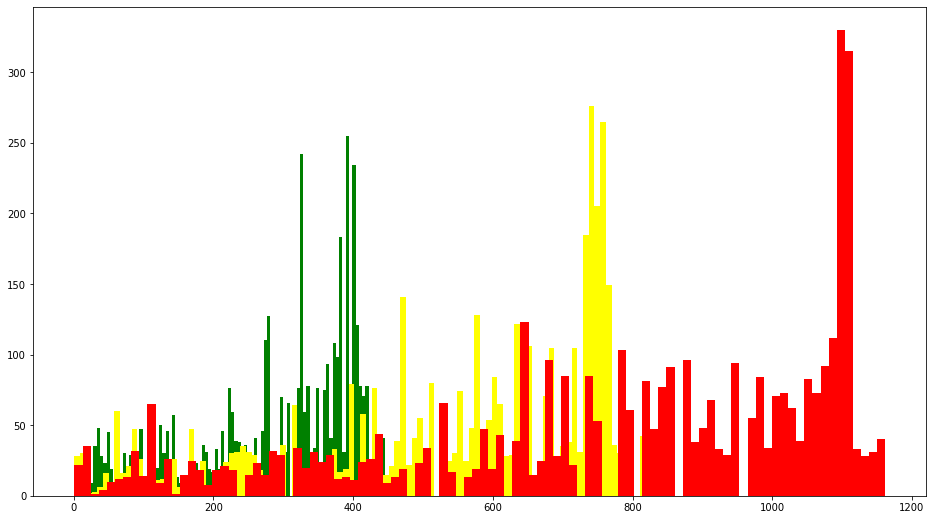

In [65]:
# plt.axis('off')
plt.hist(f5, color='green', bins=100)
plt.hist(f10, color='yellow', bins=100)
plt.hist(f15, color='red', bins=100)
plt.xlabel('', fontsize=16)
plt.ylabel('')
# plt.show()
plt.savefig('deg_hist.png', dpi=601, bbox_inches = 'tight',
    pad_inches = 0)

In [71]:
p = 999
p/(p*(p-1))

0.001002004008016032